In [23]:
import os

import torch
from glob import glob
from scipy import ndimage
import math
import json
import numpy as np

import cv2
from matplotlib import pyplot as plt
import matplotlib

from pathlib import Path
from math import sin, cos
from dotenv import load_dotenv

from ultralytics import YOLO

from utils.yolo import get_teeth_ROI
from utils.edge import tooth_isolation, gum_jaw_separation, vertical_separation, bounding_teeth_on_origin
from utils.preprocess import recovery_rotated_bounding, xyxy2xywh, get_image_by_labels, get_labels_by_image
from utils.preprocess import xyxy_reformat, rotate_bounding_boxes, rect_include_another

matplotlib.use('module://matplotlib_inline.backend_inline')
# %matplotlib inline
load_dotenv()


True

In [2]:
target_labels = ['caries', 'endo', 'post', 'crown']
image_labels_df = get_image_by_labels(target_labels)[target_labels]

image_labels_df


,caries,endo,post,crown
filename,,,,
20180716060731353968_000351,0,1,1,1
202011280311178751869_0460103A,0,15,2,17
201806270806586650_000063,0,4,0,2
201808060608235842214_000582,5,0,0,0
202011200611597931737_0701103A,0,2,0,0
...,...,...,...,...
00008336,0,4,1,3
201806280906437051_000067,0,0,1,1
201809100509288484538_000846,1,1,0,0


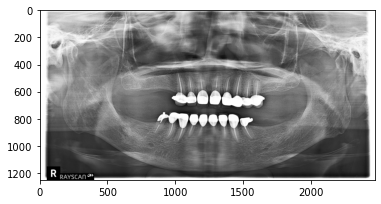

In [24]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'

filename = image_labels_df.index[1]
filepath_image = data_dir / f'{filename}.jpg'
filepath_json = data_dir / f'{filename}.json'

im_0 = cv2.imread(filepath_image)
plt.imshow(im_0)
plt.show()


# Demo rotation

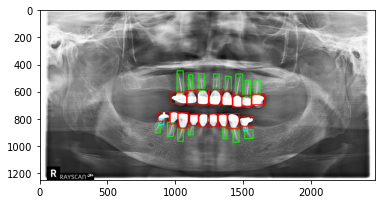

In [6]:
# TODO draw annotation bounding box
labels = get_labels_by_image(filepath_json, target_labels)
colors_dict = {target_labels[i - 1]: [int(j) * 255 for j in bin(i)[2:].zfill(3)] for i in
               range(1, len(target_labels) + 1)}

im_annotated = im_0.copy()

for label in labels:
    xyxy = np.array([np.hstack(label['points'])]).astype(int)
    xyxy = xyxy_reformat(xyxy)[0]
    color = colors_dict[label['label']]

    im_annotated = cv2.rectangle(im_annotated, xyxy[:2], xyxy[2:], color, thickness=5)

plt.imshow(im_annotated)
plt.show()


In [29]:
yolo_model_dir = Path(os.getenv('YOLO_MODEL_DIR'))
yolo_dir = yolo_model_dir / '..'
model = YOLO(yolo_model_dir / 'enumerate.pt')
# Image
# Inference
results = model(filepath_image)

results[0].file

teeth_roi = get_teeth_ROI(results)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']
teeth_roi_split_teeth



image 1/1 /Users/lucyxu/PycharmProjects/datasets/phase-2/202011280311178751869_0460103A.jpg: 352x640 1 11, 1 12, 1 13, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 32, 2 33s, 1 34, 1 35, 2 42s, 2 43s, 2 44s, 69.5ms
Speed: 1.5ms preprocess, 69.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'Results' object has no attribute 'file'. See valid attributes below.

    A class for storing and manipulating inference results.

    Args:
        orig_img (numpy.ndarray): The original image as a numpy array.
        path (str): The path to the image file.
        names (dict): A dictionary of class names.
        boxes (List[List[float]], optional): A list of bounding box coordinates for each detection.
        masks (numpy.ndarray, optional): A 3D numpy array of detection masks, where each mask is a binary image.
        probs (numpy.ndarray, optional): A 2D numpy array of detection probabilities for each class.
        keypoints (List[List[float]], optional): A list of detected keypoints for each object.


    Attributes:
        orig_img (numpy.ndarray): The original image as a numpy array.
        orig_shape (tuple): The original image shape in (height, width) format.
        boxes (Boxes, optional): A Boxes object containing the detection bounding boxes.
        masks (Masks, optional): A Masks object containing the detection masks.
        probs (numpy.ndarray, optional): A 2D numpy array of detection probabilities for each class.
        names (dict): A dictionary of class names.
        path (str): The path to the image file.
        keypoints (List[List[float]], optional): A list of detected keypoints for each object.
        speed (dict): A dictionary of preprocess, inference and postprocess speeds in milliseconds per image.
        _keys (tuple): A tuple of attribute names for non-empty attributes.
    

In [ ]:
tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}

target_roi = teeth_roi_images[3]
target_roi_image = target_roi['image']
flag = target_roi['flag']
tooth_position = tooth_position_dict[target_roi['number']]
im_g = cv2.cvtColor(target_roi_image, cv2.COLOR_RGBA2GRAY)

isolation_data = tooth_isolation(im_g, flag=flag, tooth_position=tooth_position, rotation_fix=False)
regions = isolation_data['crop_regions']
theta = isolation_data['angle']
offset = target_roi['offset']

regions


In [ ]:
target_roi_image_annotated = 1 - target_roi_image.copy()

for label in labels:
    xyxy = np.hstack(label['points'])
    xyxy = xyxy - np.tile(offset, 2)
    xyxy = xyxy.astype(int)
    xywh = xyxy2xywh(np.array([xyxy])).astype(int)[0]
    color = colors_dict[label['label']]

    target_roi_image_annotated = cv2.rectangle(target_roi_image_annotated, xyxy[:2], xyxy[2:], color, thickness=5)

plt.imshow(target_roi_image_annotated)
plt.show()


In [ ]:
image_roi_rotated = ndimage.rotate(target_roi_image_annotated, theta)

image_roi_rotated_teeth = image_roi_rotated.copy()
for tooth_number, data in regions.items():
    xyxy = data['xyxy']
    image_roi_rotated_teeth = cv2.rectangle(image_roi_rotated_teeth, xyxy[:2], xyxy[2:], (255, 255, 0), thickness=5)

plt.imshow(image_roi_rotated_teeth)
plt.show()
regions


In [ ]:
phi = math.radians(theta)
im_g_shape = np.array(np.array(im_g.shape)[[1, 0]])
image_roi_rotated_teeth_annotated = image_roi_rotated_teeth.copy()
labels_rotated = []
for label in labels:
    xyxy = np.hstack(label['points'])  # [x, y, x, y]
    xyxy = xyxy_reformat(np.array([xyxy]))

    xyxy = xyxy - np.tile(offset, 2)
    xyxy = rotate_bounding_boxes(phi, im_g_shape, xyxy)

    color = colors_dict[label['label']]
    xyxy = xyxy[0].astype(int)

    if xyxy.min() < 0 or np.any(xyxy[2:] > im_g_shape[[1, 0]]):
        continue

    labels_rotated.append(xyxy)
    image_roi_rotated_teeth_annotated = cv2.rectangle(image_roi_rotated_teeth_annotated, xyxy[:2], xyxy[2:], color,
                                                      thickness=5)

plt.imshow(image_roi_rotated_teeth_annotated)
plt.show()

# xyxy[[1, 3]]


In [ ]:
image_labels = {}

for label in labels:
    xyxy = np.hstack(label['points'])  # [x, y, x, y]
    xyxy = xyxy_reformat(np.array([xyxy]))

    xyxy = xyxy - np.tile(offset, 2)
    if xyxy.min() < 0:
        continue

    xyxy = rotate_bounding_boxes(phi, im_g_shape, xyxy)
    xyxy = xyxy[0].astype(int)

    for tooth_number, region in regions.items():
        tooth_xyxy = region['xyxy']
        if rect_include_another(tooth_xyxy, xyxy) > 0.5:
            key = f'{filename}-{tooth_number}'
            if not key in image_labels.keys():
                image_labels[key] = []
            image_labels[key].append(label['label'])

image_labels
